#### REFERENCES

In [2]:
# References:
# huffman encoding and compression

# https://narainsreehith.medium.com/huffman-coding-on-image-d6092bed5821

# https://stackoverflow.com/questions/70752690/how-do-i-decompress-files-using-huffman-compression

### APPLICATION FOR IMAGE MANIPULATION

In [3]:
import tkinter as tk
from tkinter import filedialog, ttk, Tk, PhotoImage
from PIL import Image, ImageTk, ImageEnhance, ImageFilter
import cv2
import numpy as np
from PIL import Image
import time
import random
import heapq
import matplotlib.pyplot as plt

In [10]:
def downscale_image(img, max_dimension):
    aspect_ratio = img.width / float(img.height)
    if img.width > img.height:
        new_width = max_dimension
        new_height = int(max_dimension / aspect_ratio)
    else:
        new_height = max_dimension
        new_width = int(max_dimension * aspect_ratio)
    return img.resize((new_width, new_height), resample=Image.LANCZOS)

class DIP_TECH:
    def __init__(self, root):
        self.root = root  # main window
        self.root.title("Assignment 2") # main window name
        
        # app styling 
        self.root.geometry("1720x880") # Application window size
        self.root.resizable(width=True, height=True) # Making window resizable
        self.root.config(bg="#1B2631")
        
        # Adding Labels and Instructions   
        self.instruction_label = tk.Label(self.root, bg="#EBEDEF", fg="black", text="Welcome to Image Processing Application", font=("Arial", 15, "italic"))
        self.instruction_label.pack(pady=10)

        style = ttk.Style()
        style.configure("Upload.TButton", foreground="#17202A", padding=(10, 5), font=("Arial", 12, "bold"))
        style.map('TButton', foreground=[('active', '!disabled', '#3498DB')], background=[('active', 'black')])

        # Div for upload button and dropdown
        self.upload_div = tk.Frame(root, bg="#34495E")
        self.upload_div.pack(pady=10)

        self.upload_button = ttk.Button(self.upload_div, text="Upload Media", command=self.upload_media, style="Upload.TButton")
        self.upload_button.pack(side=tk.LEFT, padx=10)

        self.processing_label = tk.Label(self.upload_div, text="Select Processing Technique", font=("Arial", 12), bg="#34495E", fg="#E74C3C")
        self.processing_label.pack(side=tk.LEFT, padx=10)

        self.processing_techniques = tk.StringVar()
        self.dropdown_menu = ttk.Combobox(self.upload_div, textvariable=self.processing_techniques, 
                                values=['Thresholding', 'Histogram Equalization', 'Averaging Filter', 'Laplacian Filter',
                                       'Adaptive Thresholding', 'K Means Segmentation', 'LoG','Erosion','Dilation','Opening','Closing','OpeningCV','ClosingCV'
                                        ,'Opening Compare','Closing Compare'],
                                font=("Arial", 12))
        self.dropdown_menu.pack(side=tk.LEFT, padx=10)
        self.dropdown_menu.bind("<<ComboboxSelected>>", self.apply_processing_technique)

        # Div for image display panels
        self.image_display_div = tk.Frame(root, bg="#34495E")
        self.image_display_div.pack(pady=10)

        self.original_panel = tk.Label(self.image_display_div)
        self.original_panel.pack(side=tk.LEFT, padx=10, pady=10)
        self.result_panel = tk.Label(self.image_display_div)
        self.result_panel.pack(side=tk.RIGHT, padx=10, pady=10)
        
        self.cv_panel = tk.Label(self.image_display_div)
        self.cv_panel.pack(side=tk.LEFT, padx=10, pady=10)

        self.sequence_div = tk.Frame(root, bg="#34495E")
        self.sequence_div.pack(pady=10)
        self.add_to_sequence_button = ttk.Button(self.sequence_div, text="Add to Sequence", command=self.add_to_sequence)
        self.add_to_sequence_button.pack(side=tk.LEFT, padx=10)

        self.apply_sequence_button = ttk.Button(self.sequence_div, text="Apply Sequence", command=self.apply_sequence)
        self.apply_sequence_button.pack(side=tk.LEFT, padx=10)

        self.clear_sequence_button = ttk.Button(self.sequence_div, text="Clear Sequence", command=self.clear_sequence)
        self.clear_sequence_button.pack(side=tk.LEFT, padx=10)
        self.sequence_display = tk.Text(self.root, height=5, width=50)
        self.sequence_display.pack(pady=10)
        
        # Div for previous and next buttons
        self.navigation_div = tk.Frame(root, bg="#34495E")
        self.navigation_div.pack(pady=10)

        self.prev_frame_button = tk.Button(self.navigation_div, text="Previous Frame", command=self.prev_frame, state=tk.DISABLED)
        self.prev_frame_button.pack(side=tk.LEFT)
        self.next_frame_button = tk.Button(self.navigation_div, text="Next Frame", command=self.next_frame, state=tk.DISABLED)
        self.next_frame_button.pack(side=tk.RIGHT)

        self.threshold_var = tk.StringVar()
        self.threshold_var.trace_add("write", self.thresholding)
        self.threshold_input = None  
        self.threshold_label = None  
        self.progress_packed = False
        self.media_path = None
        self.original_image = None
        self.original_image_copy=None
        self.sequence_image= None
        self.result_image = None
        self.video = None
        self.current_frame = 0
        self.total_frames = 0
        
        # Technique sequence
        self.technique_sequence = []
        
        self.kernel_names = ['plus', 'cross', 'diamond', 'disk', 'square']
        
    # GUI Components

    def clear_result_panel(self):
        self.result_panel.configure(image='')
        self.result_panel.image = None 
        
    def update_sequence_display(self):
            self.sequence_display.delete('1.0', tk.END)
            for technique in self.technique_sequence:
                self.sequence_display.insert(tk.END, technique + '\n')
                
    def add_to_sequence(self):
        technique = self.processing_techniques.get()
        if technique:
            self.technique_sequence.append(technique)
            self.update_sequence_display()
            # print(f"Added {technique}. Current sequence: {self.technique_sequence}")

    def apply_sequence(self):
        self.clear_result_panel()
        if self.original_image:
            self.sequence_image = self.original_image
            for tech in self.technique_sequence:
                # print(tech)
                self.apply_technique(tech)
    def clear_sequence(self):
        self.technique_sequence = []
        self.update_sequence_display()
        
    def apply_technique(self,  technique):
        self.original_image=self.sequence_image
        if self.threshold_input:
            self.threshold_input.pack_forget()
        if self.threshold_label:
            self.threshold_label.pack_forget()
        
        # print('check1')
        if technique == 'Thresholding': 
            self.threshold_label = tk.Label(self.root, text ='Threshold Value', font="Arial 15")  
            self.threshold_label.pack()
            
            sp = ttk.Spinbox(self.root, from_=0, to=255, textvariable=self.threshold_var)
            sp.pack() 
            
            # Store the Spinbox widget reference
            self.threshold_input = sp
            
            self.thresholding(sp.get())
            # print('check2')
        elif technique == 'Histogram Equalization':
            self.apply_histogram_eq()
            # print('check3')
        elif technique == 'Averaging Filter':
            self.averaging_filter()
            # print('check4')
        elif technique == 'Laplacian Filter':
            self.laplacian_filter()
            # print('check5')
        elif technique == 'Adaptive Thresholding':
            self.adaptive_thresholding()
            # print('check6')
        elif technique == 'K Means Segmentation':
            self.k_means_segmentation()
            # print('check7')
        elif technique == 'LoG':
            self.LoG()
            
        elif technique == 'Erosion':
            kernel = self.get_structuring_element(name = random.choice(self.kernel_names), size = self.get_structuring_element_size())
            self.erode(np.array(self.thresholding_basic(self.original_image)), kernel)
            
        elif technique == 'Dilation':
            kernel = self.get_structuring_element(name = random.choice(self.kernel_names), size = self.get_structuring_element_size())
            self.dilate(np.array(self.thresholding_basic(self.original_image)), kernel)
            
        elif technique == 'Opening':
            kernel = self.get_structuring_element(name = random.choice(self.kernel_names), size = self.get_structuring_element_size())
            self.open_image(np.array(self.thresholding_basic(self.original_image)), kernel)
            
        elif technique == 'Closing':
            kernel = self.get_structuring_element(name = random.choice(self.kernel_names), size = self.get_structuring_element_size())
            self.close_image(np.array(self.thresholding_basic(self.original_image)), kernel)
            
        elif technique == 'OpeningCV':
            kernel = self.get_structuring_element(name = random.choice(self.kernel_names), size = self.get_structuring_element_size())
            self.show_image(self.open_image_cv(kernel),'result')
            
        elif technique == 'ClosingCV':
            kernel = self.get_structuring_element(name = random.choice(self.kernel_names), size = self.get_structuring_element_size())
            self.show_image(self.close_image_cv(kernel),'result')
            
        elif technique == 'Opening Compare':
            kernel = self.get_structuring_element(name = random.choice(self.kernel_names), size = self.get_structuring_element_size())
            self.open_image(np.array(self.thresholding_basic(self.original_image)), kernel)
            opened_cv = self.open_image_cv(np.uint8(kernel))
            # self.show_image(opened_custom, "result")
            self.show_image(opened_cv, "cv_result")
        
        elif technique == 'Closing Compare':
            kernel = self.get_structuring_element(name = random.choice(self.kernel_names), size = self.get_structuring_element_size())
            closed_custom = self.close_image(np.array(self.thresholding_basic(self.original_image)), kernel)
            closed_cv = self.close_image_cv(np.uint8(kernel))
            # self.show_image(closed_custom, "result")
            self.show_image(closed_cv, "cv_result")

    def filter2D(self,image, kernel):
        # Get the dimensions of the image and the kernel
        image_height, image_width = image.shape
        kernel_height, kernel_width = kernel.shape
    
        # Compute the padding needed for the image
        pad_height = kernel_height // 2
        pad_width = kernel_width // 2
    
        # Pad the image with zeros
        padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant')
    
        # Create an empty array to store the filtered image
        filtered_image = np.zeros_like(image)
    
        # Apply the convolution operation
        for i in range(image_height):
            for j in range(image_width):
                # Extract the region of interest from the padded image
                region = padded_image[i:i + kernel_height, j:j + kernel_width]
                # Perform element-wise multiplication between the kernel and the region
                convolution_result = np.sum(region * kernel)
                # Store the result in the filtered image
                filtered_image[i, j] = convolution_result
    
        return filtered_image

    # Functions remain the same
    def gaussian_blur(self,image, size, sigma):
        kernel = np.fromfunction(lambda x, y: (1/(2*np.pi*sigma**2)) * np.exp(-((x - size//2)**2 + (y - size//2)**2)/(2*sigma**2)), (size, size))
        kernel = kernel / np.sum(kernel)
        return self.filter2D(image, kernel)

    def laplacian_filter_log(self,image):
        laplacian_kernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
        filtered_image = self.filter2D(image, laplacian_kernel)
        return filtered_image 
    
    def upload_media(self):
        file_type = [("images", "*.jpg *.jpeg *.png"), ("video", "*.mp4 *.avi")]
        self.media_path = filedialog.askopenfilename(filetypes=file_type)
    
        if self.media_path:
            
            if self.progress_packed:
                self.progress.pack_forget()
                self.progress_packed = False

            if self.media_path.endswith(('.jpg', '.jpeg', '.png')):
                self.original_image = Image.open(self.media_path)
                self.original_image_copy= self.original_image
                self.show_image(self.original_image, panel="original")
                
                # Clear the result panel when uploading new media
                self.result_panel.configure(image=None)
                self.result_panel.image = None
                
                self.video = None
                
                # Disable Next Frame and Previous Frame buttons for images
                self.next_frame_button.config(state=tk.DISABLED)
                self.prev_frame_button.config(state=tk.DISABLED)
                
            else:
                self.video = cv2.VideoCapture(self.media_path)
                self.current_frame = 0
                self.show_frame()
                self.next_frame_button.config(state=tk.NORMAL)
                self.progress = ttk.Progressbar(self.root, orient=tk.HORIZONTAL, length=100, mode='determinate')
                self.progress.pack(pady=10)
                self.progress_packed = True

    def show_image(self, image, panel="original"):

        max_dimension = 500  # Specify the maximum dimension (either width or height)
        img = downscale_image(image, max_dimension)
        img = ImageTk.PhotoImage(img)
        
        if(self.video):
            if self.current_frame > 0:
                 self.prev_frame_button.config(state=tk.NORMAL)
            elif self.current_frame == 0:
                self.prev_frame_button.config(state=tk.DISABLED)

            if self.current_frame == self.total_frames - 1:
                self.next_frame_button.config(state=tk.DISABLED)
            elif (self.current_frame != self.total_frames - 1) and (self.current_frame != 0):
                self.next_frame_button.config(state=tk.NORMAL)
            
        if panel == "original":
            self.original_panel.configure(image=img)
            self.original_panel.image = img
            
        elif panel == "result":
            self.result_panel.configure(image=img)
            self.result_panel.image = img
            self.cv_panel.configure(image='')
            self.cv_panel.image = None
            # print("show image")
        elif panel == "cv_result":
            self.cv_panel.configure(image=img)
            self.cv_panel.image = img
       
    def next_frame(self):
        if self.video is not None:
            self.total_frames = int(self.video.get(cv2.CAP_PROP_FRAME_COUNT))
            
            if self.current_frame < self.total_frames - 1:
                self.current_frame += 1
                
                # Updating progress bar for frames
                self.progress['value'] = int((self.current_frame / self.total_frames) * 100)
                self.root.update_idletasks()
                self.show_frame()

    def show_frame(self):
        if self.video is not None:
            self.video.set(cv2.CAP_PROP_POS_FRAMES, self.current_frame)
            ret, frame = self.video.read()
            
            if ret:
                cv2image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
                img = Image.fromarray(cv2image)
                self.show_image(img)
                self.original_image=img
                self.original_image_copy= img
                self.apply_processing_technique()
                
    def prev_frame(self):
        if self.video is not None:
            self.total_frames = int(self.video.get(cv2.CAP_PROP_FRAME_COUNT))
            
            if self.current_frame > 0:
                self.current_frame -= 1
                
                # Updating progress bar for frames
                self.progress['value'] = int((self.current_frame / self.total_frames) * 100)
                self.root.update_idletasks()
                self.show_frame()
                
    def get_structuring_element_size(self, scaler=17):    
        size = (np.array(self.original_image).shape[0] // scaler)
        if(size % 2 ==0):
            size += 1     
        return (size, size)
    
    def get_structuring_element(self, name, size):
    
        if isinstance(size, int):
            size = (size, size)  # Convert to tuple for consistency

        if name.lower() == "plus":
            plus = np.zeros(size, dtype=np.uint8)
            center = size[0] // 2
            plus[center, :] = 1
            plus[:, center] = 1
            return plus

        elif name.lower() == "cross":
            cross = np.zeros(size, dtype=np.uint8)
            cross[np.arange(size[0]), np.arange(size[1])] = 1
            cross[np.arange(size[0]), np.arange(start = size[1]-1, stop=-1, step=-1)] = 1
            return cross

        elif name.lower() == "disk":
            diameter = min(size)
            radius = diameter // 2
            y, x = np.ogrid[-radius:radius+1, -radius:radius+1]
            mask = x**2 + y**2 <= radius**2
            disk = np.zeros(size, dtype=np.uint8)
            disk[mask] = 1
            return disk

        elif name.lower() == "square":
            return np.ones(size, dtype=np.uint8)

        elif name.lower() == "diamond":
            diamond = np.zeros(size, dtype=np.uint8)
            center = size[0] // 2
            y, x = np.ogrid[:size[0], :size[1]]
            diamond[np.abs(x - center) + np.abs(y - center) <= center] = 1
            return diamond
        else:
            raise ValueError("Invalid structuring element name")        
           
    def apply_processing_technique(self,event=None):
        
        technique = self.processing_techniques.get()
        self.original_image=self.original_image_copy
        
        # Hide the Spinbox if it exists
        if self.threshold_input:
            self.threshold_input.pack_forget()
        if self.threshold_label:
            self.threshold_label.pack_forget()
        
        if technique == 'Thresholding': 
            self.threshold_label = tk.Label(self.root, text ='Threshold Value', font="Arial 15")  
            self.threshold_label.pack()
            
            sp = ttk.Spinbox(self.root, from_=0, to=255, textvariable=self.threshold_var)
            sp.pack() 
            
            # Store the Spinbox widget reference
            self.threshold_input = sp
            
            self.thresholding(sp.get())
            
        elif technique == 'Histogram Equalization':
            self.apply_histogram_eq()
            
        elif technique == 'Averaging Filter':
            self.averaging_filter()
            
        elif technique == 'Laplacian Filter':
            self.laplacian_filter()
            
        elif technique == 'Adaptive Thresholding':
            self.adaptive_thresholding()
            
        elif technique == 'K Means Segmentation':
            self.k_means_segmentation()
            
        elif technique == 'LoG':
            self.LoG()
            
        elif technique == 'Erosion':
            kernel = self.get_structuring_element(name = random.choice(self.kernel_names), size = self.get_structuring_element_size())
            self.erode(np.array(self.thresholding_basic(self.original_image)), kernel)
            
        elif technique == 'Dilation':
            kernel = self.get_structuring_element(name = random.choice(self.kernel_names), size = self.get_structuring_element_size())
            self.dilate(np.array(self.thresholding_basic(self.original_image)), kernel)
            
        elif technique == 'Opening':
            kernel = self.get_structuring_element(name = random.choice(self.kernel_names), size = self.get_structuring_element_size())
            self.open_image(np.array(self.thresholding_basic(self.original_image)), kernel)
            
        elif technique == 'Closing':
            kernel = self.get_structuring_element(name = random.choice(self.kernel_names), size = self.get_structuring_element_size())
            self.close_image(np.array(self.thresholding_basic(self.original_image)), kernel)
            
        elif technique == 'OpeningCV':
            kernel = self.get_structuring_element(name = random.choice(self.kernel_names), size = self.get_structuring_element_size())
            self.show_image(self.open_image_cv(kernel),'result')
            
        elif technique == 'ClosingCV':
            kernel = self.get_structuring_element(name = random.choice(self.kernel_names), size = self.get_structuring_element_size())
            self.show_image(self.close_image_cv(kernel),'result')
            
        elif technique == 'Opening Compare':
            kernel = self.get_structuring_element(name = random.choice(self.kernel_names), size = self.get_structuring_element_size())
            self.open_image(np.array(self.thresholding_basic(self.original_image)), kernel)
            opened_cv = self.open_image_cv(np.uint8(kernel))
            # self.show_image(opened_custom, "result")
            self.show_image(opened_cv, "cv_result")
        
        elif technique == 'Closing Compare':
            kernel = self.get_structuring_element(name = random.choice(self.kernel_names), size = self.get_structuring_element_size())
            closed_custom = self.close_image(np.array(self.thresholding_basic(self.original_image)), kernel)
            closed_cv = self.close_image_cv(np.uint8(kernel))
            # self.show_image(closed_custom, "result")
            self.show_image(closed_cv, "cv_result")

    # Implementing the same processing functions as before
    def thresholding(self, *args):
        try:
            threshold_value = int(self.threshold_var.get())
        except ValueError: 
            threshold_value = 128
        
        if self.original_image:
            gray = self.original_image.convert('L')
            threshold_image = gray.point(lambda x: 0 if x < threshold_value else 255, '1')
            self.show_image(threshold_image, "result")
            self.sequence_image=threshold_image
            # self.sequence_image=ImageTk.PhotoImage(threshold_image)
            
    def averaging_filter(self):
        if self.original_image:
            avg_img=self.original_image.filter(ImageFilter.BoxBlur(5))
            self.show_image(avg_img, "result")
            self.sequence_image=avg_img
            # self.sequence_image=ImageTk.PhotoImage(avg_img)

    def laplacian_filter(self):
        if self.original_image:
            numpy_image = np.array(self.original_image.convert('L'))
            lap_img=Image.fromarray(np.uint8(np.absolute(cv2.Laplacian(numpy_image, cv2.CV_64F))))
            self.show_image(lap_img, "result")
            # self.sequence_image=ImageTk.PhotoImage(lap_img)
            self.sequence_image=lap_img
            
    def apply_histogram_eq(self):
        if self.original_image:
            gray = self.original_image.convert('L')
            his_img=Image.fromarray(cv2.equalizeHist(np.array(gray)))
            self.show_image(his_img, "result")
            self.sequence_image=ImageTk.PhotoImage(his_img)
            self.sequence_image=his_img
            
    def adaptive_thresholding(self):
        if self.original_image:
            
            BLOCK_SIZE = 3  
            C = 10 
            image = np.array(self.original_image.convert('L'))
            
            rows, cols = image.shape
            thresholded_image = np.zeros_like(image)
            pad_width = BLOCK_SIZE // 2
            padded_image = np.pad(image, pad_width, mode='constant', constant_values=int(np.mean(image)))

            for i in range(0, rows):
                for j in range(0, cols):
                    block = padded_image[i : i + BLOCK_SIZE, j : j + BLOCK_SIZE]
                    threshold = np.mean(block) - C
                    thresholded_image[i,j] = 255 if image[i,j] > threshold else 0

            self.show_image(Image.fromarray(thresholded_image), "result")
            self.sequence_image=Image.fromarray(thresholded_image)
            # self.sequence_image=ImageTk.PhotoImage(Image.fromarray(thresholded_image))
            
    def k_means_segmentation(self):
        if self.original_image:
            k = 3
            
            image = np.array(self.original_image.convert('L'))
            rows, cols = image.shape
            image_pixels = image.reshape(-1, 1)
            centroids = np.random.randint(0, 256, size=(k, 1))
        #     max_iterations = 100
        #     for _ in range(max_iterations):
            while(1):
                
                distances = np.abs(image_pixels - centroids.T)
                classes = np.argmin(distances, axis=1)
                new_centroids = np.array([np.mean(image_pixels[classes == cluster_num]) for cluster_num in range(k)])

                if np.all(centroids == new_centroids):
                    break

                centroids = new_centroids

            segmented_image = centroids[classes].reshape(rows, cols)
            self.show_image(Image.fromarray(segmented_image.astype(np.uint8)), "result")
            # self.sequence_image=ImageTk.PhotoImage(Image.fromarray(segmented_image.astype(np.uint8)))
            self.sequence_image=Image.fromarray(segmented_image.astype(np.uint8))
    def LoG(self):
        if self.original_image:
            gray = np.array(self.original_image.convert('L'))
            log_img=Image.fromarray(self.laplacian_filter_log(self.gaussian_blur(gray, 3, 1)))
            self.show_image(log_img, "result")
            self.sequence_image=log_img
            # self.sequence_image=ImageTk.PhotoImage(log_img)
            
    def erode(self,image, kernel):
        kernel_height, kernel_width = kernel.shape
        image_height, image_width = image.shape
        pad_height = kernel_height // 2
        pad_width = kernel_width // 2
        
        # Pad the image
        padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant', constant_values=(0, 0))
        output_image = np.zeros_like(image)
        for i in range(image_height):
            for j in range(image_width):
                region = padded_image[i:i + kernel_height, j:j + kernel_width]
                if np.all((region[kernel == 1]) == 1):
                    output_image[i, j] = 1
        
        erode_image= Image.fromarray(output_image)
        self.show_image(erode_image, "result")
        self.sequence_image=erode_image
    
    
    def dilate(self,image, kernel):
        
        kernel_height, kernel_width = kernel.shape
        image_height, image_width = image.shape
        pad_height = kernel_height // 2
        pad_width = kernel_width // 2
        
        padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant', constant_values=(0, 0))
        output_image = np.zeros_like(image)
        
        for i in range(image_height):
            for j in range(image_width):
                region = padded_image[i:i + kernel_height, j:j + kernel_width]
                if np.any(region & kernel):
                    output_image[i, j] = 1
        
        dilated_image= Image.fromarray(output_image)
        self.show_image(dilated_image, "result")
        self.sequence_image=dilated_image
        
    def thresholding_basic(self,image):
        threshold_value = 128
        gray = image.convert('L')
        threshold_image = gray.point(lambda x: 0 if x < threshold_value else 255, '1')
        return threshold_image
    
    def open_image(self,image, kernel):
        self.erode(image, kernel)
        self.dilate(np.array(self.sequence_image), kernel)
        
    def close_image(self,image, kernel):
        self.dilate(image, kernel)
        self.erode(np.array(self.sequence_image), kernel)
        
    def open_image_cv(self, kernel):
        # Assuming self.original_image is a PIL image
        image = cv2.cvtColor(np.array(self.original_image), cv2.COLOR_RGB2GRAY)
        _, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)
        result = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)
        result_image = Image.fromarray(result)
        return result_image
    
    def close_image_cv(self, kernel):
        # Assuming self.original_image is a PIL image
        image = cv2.cvtColor(np.array(self.original_image), cv2.COLOR_RGB2GRAY)
        _, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY)
        result = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)
        result_image = Image.fromarray(result)
        return result_image

def main():
    root = tk.Tk()  
    app = DIP_TECH(root)
    root.mainloop()

if __name__ == "__main__":
    main()

### IMAGE COMPRESSION WITH HUFFMAN

In [4]:
def histogram_equal_cv2(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    eq_img = cv2.equalizeHist(img)
    return Image.fromarray(eq_img)

def custom_histogram_equal(image):
    image_array = np.asarray(image)
    original_shape = image_array.shape
    flattened_image_array = image_array.flatten()
    histogram = np.bincount(flattened_image_array, minlength=256)
    cdf = np.cumsum(histogram)
    cdf_normalized = (cdf - cdf.min()) * 255 / (cdf.max() - cdf.min())  # Normalize to range 0-255
    cdf_normalized = cdf_normalized.astype(np.uint8)
    equalized_image_array = cdf_normalized[flattened_image_array]
    equalized_image = Image.fromarray(equalized_image_array.reshape(original_shape))
    return equalized_image

def plot_histogram(image, title):
    plt.figure(figsize=(6, 4))
    plt.hist(np.array(image).ravel(), bins=256, range=[0, 256], color='blue', alpha=0.75)
    plt.title(title)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    
class Nodes:
    def __init__(self, left=None, right=None, root=None):
        self.left = left
        self.right = right
        self.root = root  # Frequency and symbol tuple (freq, sym)

    def __lt__(self, other):
        return self.root[0] < other.root[0]

class Compress_huffman:
    def __init__(self, image):
        self.image = image.convert('L')  # Ensure image is grayscale
        self.frequency = {}
        self.heap = []
        self.codes = {}
        self.reverse_mapping = {}

    def calculate_freq(self):
        img_array = np.array(self.image)
        for pixel in img_array.flatten():
            if pixel in self.frequency:
                self.frequency[pixel] += 1
            else:
                self.frequency[pixel] = 1

    def make_heap(self):
        for key in self.frequency:
            node = Nodes(root=(self.frequency[key], key))
            heapq.heappush(self.heap, node)
            
    def merge_nodes(self):
        while len(self.heap) > 1:
            node1 = heapq.heappop(self.heap)
            node2 = heapq.heappop(self.heap)
            merged = Nodes(left=node1, right=node2, root=(node1.root[0] + node2.root[0], None))
            heapq.heappush(self.heap, merged)

    def make_codes_helper(self, node, current_code):
        if node.left is None and node.right is None:
            self.codes[node.root[1]] = current_code
            self.reverse_mapping[current_code] = node.root[1]
            return
        self.make_codes_helper(node.left, current_code + "0")
        self.make_codes_helper(node.right, current_code + "1")

    def make_codes(self):
        root = heapq.heappop(self.heap)
        current_code = ""
        self.make_codes_helper(root, current_code)

    def image_compress(self):
        self.calculate_freq()
        self.make_heap()
        self.merge_nodes()
        self.make_codes()
        img_array = np.array(self.image)
        encoded_output = [self.codes[pixel] for pixel in img_array.flatten()]
        total_encoded_bits = sum(len(code) for code in encoded_output)
        return total_encoded_bits / (img_array.shape[0] * img_array.shape[1])  # Average bits per pixel

Compression ratio: 6.718719618055555


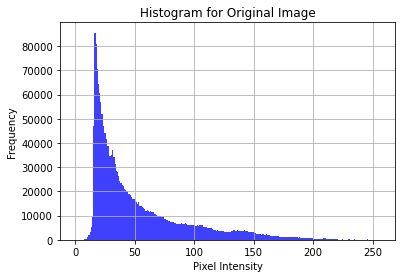

In [5]:
PATH = './northern-lights-1250561_1920.jpg'

original_img = Image.open(PATH).convert('L')
huffman = Compress_huffman(original_img)
compression_ratio = huffman.image_compress()
print("Compression ratio:", compression_ratio)
plot_histogram(original_img, "Histogram for Original Image")

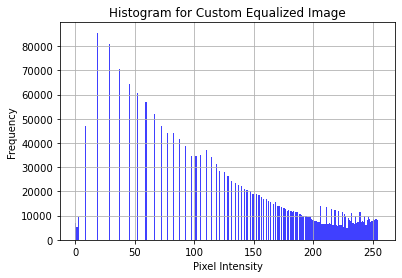

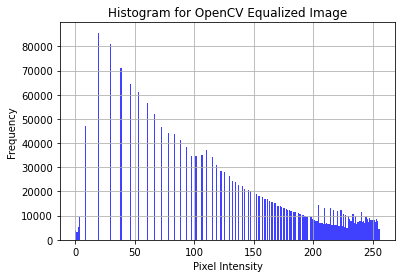

In [6]:
image = cv2.imread(PATH)
jpeg_quality = int(max(0, min(100, 100 - compression_ratio)))
cv2.imwrite("compressed_image.jpg", image, [cv2.IMWRITE_JPEG_QUALITY, jpeg_quality])

equalized_img = custom_histogram_equal(Image.open(PATH).convert('L'))
plot_histogram(equalized_img, "Histogram for Custom Equalized Image")

opencv_equalized_img = histogram_equal_cv2(PATH)
plot_histogram(opencv_equalized_img, "Histogram for OpenCV Equalized Image")

### IMAGE COMPRESSION USING SVD

In [7]:
def compress_image(image_path, k):
    img = Image.open(image_path)
    img_gray = img.convert('L')
    img_array = np.array(img_gray)
    
    U, S, V = np.linalg.svd(img_array)
    U_k = U[:, :k]
    S_k = np.diag(S[:k])
    V_k = V[:k, :]
    
    compressed_img_array = np.dot(U_k, np.dot(S_k, V_k))
    compressed_img = Image.fromarray(compressed_img_array.astype('uint8'), 'L')
    return compressed_img

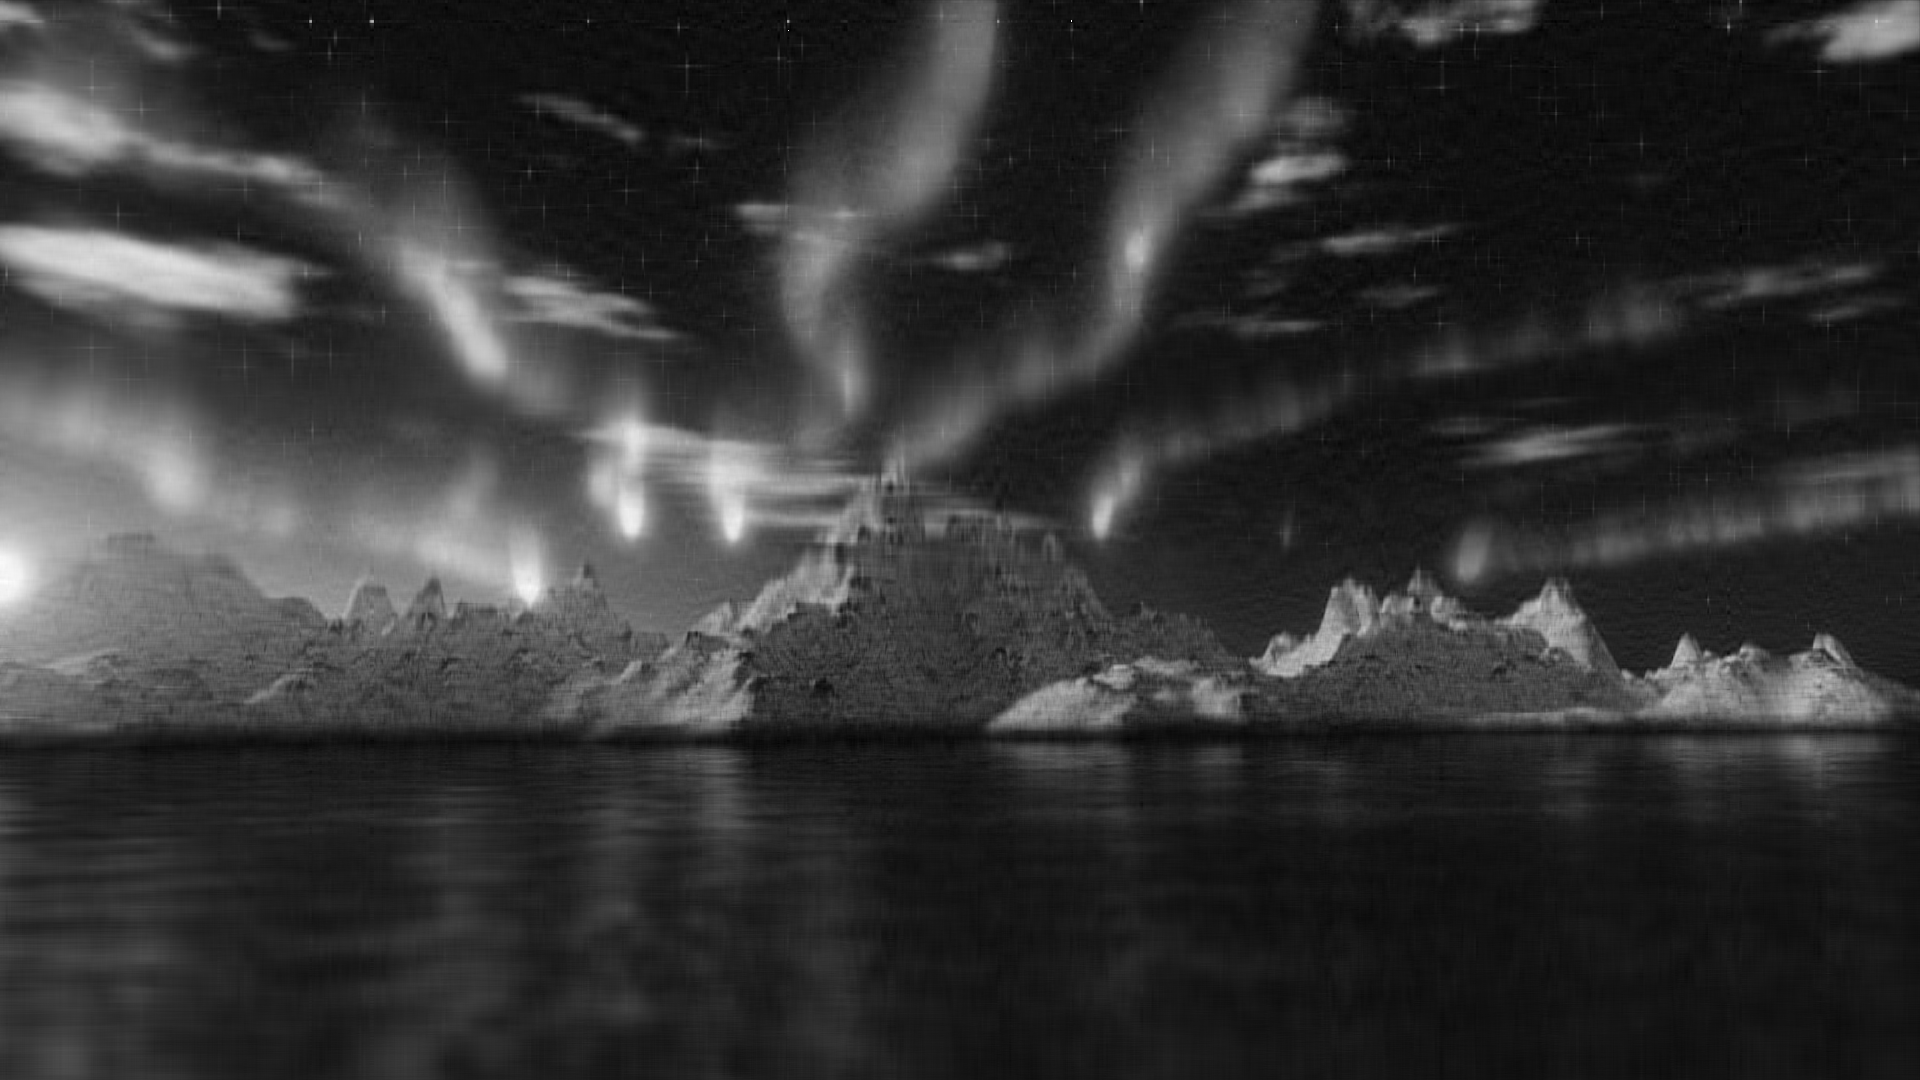

In [13]:
k = 60  # Number of singular values to keep, more values = more quality preserved
compressed_img = compress_image(PATH, k)
compressed_img  

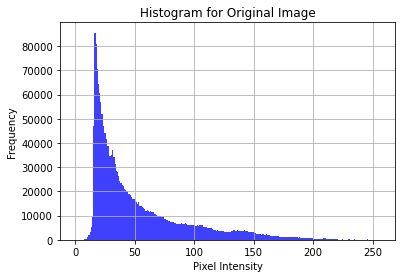

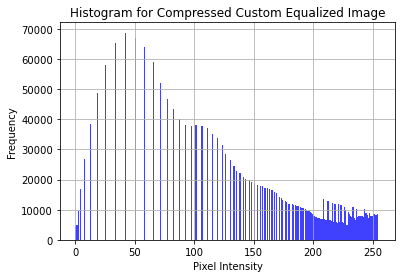

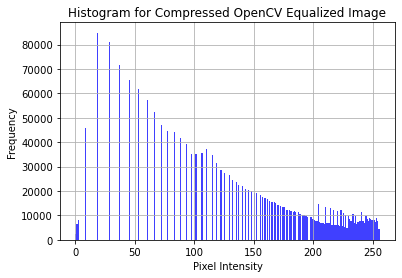

In [14]:
original_img = Image.open(PATH).convert('L')
plot_histogram(original_img, "Histogram for Original Image")

equalized_img = custom_histogram_equal(compressed_img)
plot_histogram(equalized_img, "Histogram for Compressed Custom Equalized Image")

image = cv2.imread(PATH)
jpeg_quality = int(max(0, min(100, 100 - compression_ratio)))
cv2.imwrite("compressed_image.jpg", image, [cv2.IMWRITE_JPEG_QUALITY, jpeg_quality])

opencv_equalized_img = histogram_equal_cv2("compressed_image.jpg")
plot_histogram(opencv_equalized_img, "Histogram for Compressed OpenCV Equalized Image")